In [1]:
!git clone https://github.com/fastai/course-v3/
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd /content/course-v3/nbs/dl2/
from exp.nb_05b import *

Cloning into 'course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.10 MiB | 39.57 MiB/s, done.
Resolving deltas: 100% (3251/3251), done.
/content/course-v3/nbs/dl2


In [2]:
def get_data():
    # path = datasets.download_data(MNIST_URL, ext='.gz')
    path = '/content/mnist.pkl.gz'
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

In [ ]:
import inspect; inspect.getsource(normalize)

'def normalize(x, m, s): return (x-m)/s\n'

In [3]:
x_train, y_train, x_valid, y_valid = get_data()
def normalize_to(x_train, x_valid):
    m, s = x_train.mean(), x_train.std()
    return (x_train-m)/s, (x_valid-m)/s
x_train, x_valid = normalize_to(x_train, x_valid)

train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1

In [19]:
# cnn
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x): return self.func(x)

def mnist_view(x): return x.view(-1, 1, 28, 28)

def flatten(x): return x.view(x.shape[0], -1)

def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_view),
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=2), nn.ReLU(),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

# cuda
class CudaCallback(Callback):
    def begin_fit(self):
        self.model = self.model.cuda()
    def begin_batch(self):
        self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()    

In [9]:
device = torch.device('cuda', 0)
torch.cuda.set_device(device)

In [10]:
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback]

nfs = [8, 16, 32, 64, 64]
model = get_cnn_model(data)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)
run.fit(3, learn)

train: [2.3262021875, tensor(0.1635, device='cuda:0')]
valid: [2.547389453125, tensor(0.0963, device='cuda:0')]
train: [2.04200328125, tensor(0.2677, device='cuda:0')]
valid: [0.9874076171875, tensor(0.6762, device='cuda:0')]
train: [0.5511869921875, tensor(0.8285, device='cuda:0')]
valid: [0.315736865234375, tensor(0.9019, device='cuda:0')]


---

- A5

In [16]:
xb = next(iter(data.train_dl))[0].view(-1, 1, 28, 28)
model = nn.Sequential(
        Lambda(mnist_view),
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=2), nn.ReLU(),
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )
model(xb).shape

torch.Size([512, 10])

In [12]:
flatten(model(xb)).shape

torch.Size([512, 10])

In [21]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, stride=stride, padding=ks//2), nn.ReLU())
class BatchXTransform(Callback):
    _order = 2
    def __init__(self, tfm): self.tfms = tfm
    def begin_batch(self): self.run.xb = self.tfms(self.xb)

def view_tfms(*size):
    def _inner(x): return x.view(*((-1,)+size)) #for example, in case of mnist, get 1,28, 28 and render -1, 1, 28, 28
    return _inner

mnist_tfms = view_tfms(1, 28, 28)

def get_cnn_layers(nfs, data):
    nfs = [1] + nfs
    return [conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) for i in range(len(nfs)-1)] + [
              nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

# we need to unpack the list since list is not a module subclass
def get_cnn_model(nfs, data):
    return nn.Sequential(*get_cnn_layers(nfs, data))

def get_runner(model, data, lr=0.6, cbs=None, opt_func=optim.SGD, loss_func=F.cross_entropy):
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

cbfs = [Recorder,
        partial(BatchXTransform, view_tfms(1, 28, 28)),
        partial(AvgStatsCallback, accuracy),
        CudaCallback]

model = get_cnn_model(nfs, data)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)
run.fit(3, learn)

train: [2.19004234375, tensor(0.1940, device='cuda:0')]
valid: [1.814592578125, tensor(0.3932, device='cuda:0')]
train: [0.66079578125, tensor(0.7854, device='cuda:0')]
valid: [0.20583251953125, tensor(0.9323, device='cuda:0')]
train: [0.17347111328125, tensor(0.9457, device='cuda:0')]
valid: [0.12720924072265624, tensor(0.9606, device='cuda:0')]


test AdaptiveAvgPool2d and Maxpool2d

---

- A9

In [34]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]

    def __call__(self, x):
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            self.act_means[idx].append(x.mean())
            self.act_stds[idx].append(x.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [35]:
model = SequentialModel(*get_cnn_layers(nfs, data))
learner, run = get_runner(model, data, cbs=cbfs)

In [36]:
run.fit(3, learner)

train: [2.02518546875, tensor(0.2744, device='cuda:0')]
valid: [1.75506953125, tensor(0.3964, device='cuda:0')]
train: [0.472329609375, tensor(0.8483, device='cuda:0')]
valid: [0.14747508544921875, tensor(0.9529, device='cuda:0')]
train: [0.400617265625, tensor(0.8773, device='cuda:0')]
valid: [1.5889125, tensor(0.5042, device='cuda:0')]


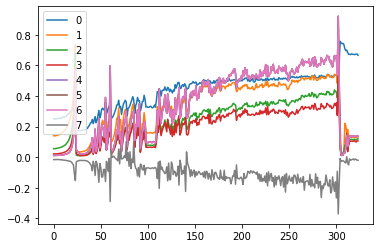

In [40]:
for l in model.act_means:
    # loop through model layers
    plt.plot(l)
plt.legend(range(len(model.act_means)))

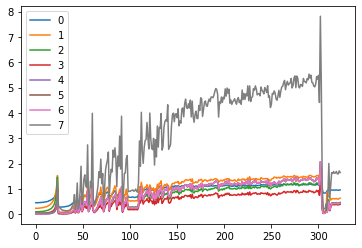

In [41]:
for l in model.act_stds:
    # loop through model layers
    plt.plot(l)
plt.legend(range(len(model.act_stds)))